http://artelab.dista.uninsubria.it/res/research/papers/2019/2019-IVCNZ-Nawaz-Birds.pdf

https://github.com/nicolalandro/ntsnet-cub200/blob/master/nts_net/model.py

In [11]:
# Standard library imports
import copy
from datetime import datetime
import os
import random
import time

# Third party imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score

# Local application imports
from helper_functions import *

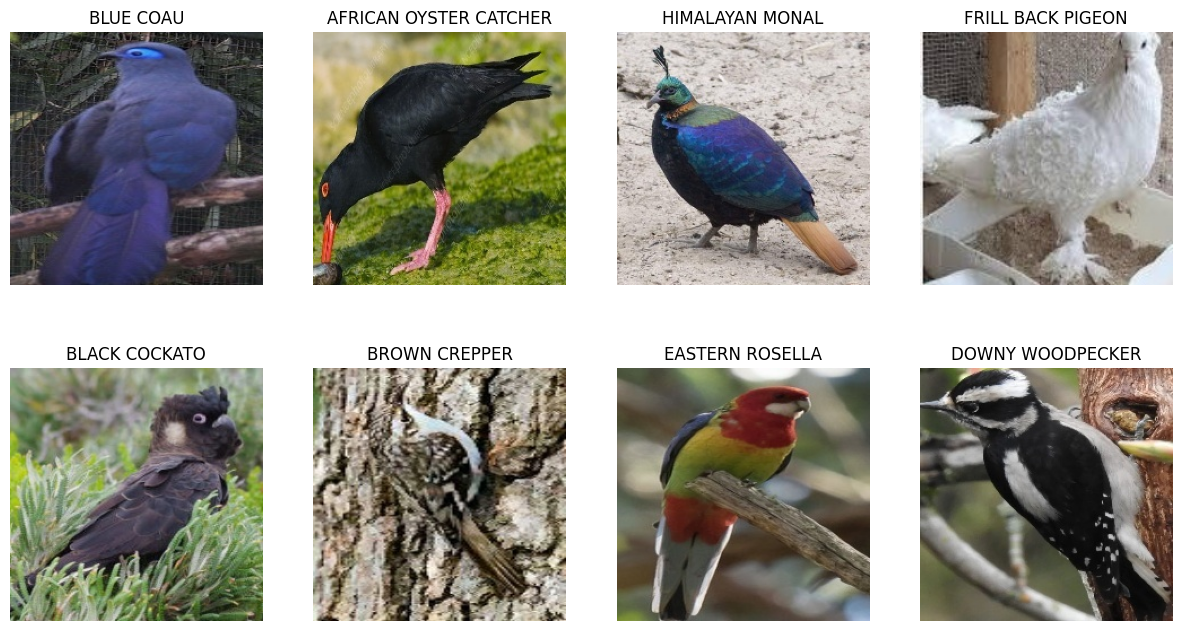

In [3]:
show_random_birbs(img_dir="bird-525/train")

In [7]:
get_height_width(path="bird-525\\train\\RED BROWED FINCH\\001.jpg")

The image size is 224 x 224


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
num_classes = 0
for root, dirs, files in os.walk("birds-525\\train-subset"):
    num_classes += len(dirs)

print(f"There are {num_classes} types of brids in the train dataset.")

There are 0 types of brids in the train dataset.


In [12]:
# Define a transform to convert the data to PyTorch Tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor()
])

# Load the training data
train_data = datasets.ImageFolder(
    root="birds-525\\train-subset",
    transform=transform
)

val_data = datasets.ImageFolder(
    root="birds-525\\valid-subset",
    transform=transform
)


# Create a data loader
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=32, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=32,
    shuffle=False
)

In [13]:
class BirbNet(nn.Module):
    def __init__(self, num_classes):
        super(BirbNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [16]:
model = BirbNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

epochs = 3
patience = 2

model, loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs, patience)

Step [10/39] | Loss: 1.6880232095718384 | Accuracy: 0.275
Step [20/39] | Loss: 1.279490351676941 | Accuracy: 0.4
Step [30/39] | Loss: 1.0429965257644653 | Accuracy: 0.5114583333333333
Epoch [1/3], Loss: 54.21716332435608, Accuracy: 0.5819209039548022, Validation Loss: 0.7173920571804047, Validation Accuracy: 0.875
Step [10/39] | Loss: 0.6950365900993347 | Accuracy: 0.88125
Step [20/39] | Loss: 0.5212661027908325 | Accuracy: 0.890625
Step [30/39] | Loss: 0.3564453125 | Accuracy: 0.9083333333333333
Epoch [2/3], Loss: 22.50523841381073, Accuracy: 0.9128329297820823, Validation Loss: 0.3561103641986847, Validation Accuracy: 0.925
Step [10/39] | Loss: 0.3727092742919922 | Accuracy: 0.940625
Step [20/39] | Loss: 0.4536702334880829 | Accuracy: 0.9390625
Step [30/39] | Loss: 0.3316865861415863 | Accuracy: 0.9385416666666667
Epoch [3/3], Loss: 14.819695770740509, Accuracy: 0.9322033898305084, Validation Loss: 0.2707165628671646, Validation Accuracy: 0.9


In [17]:
save_model(model, "./models/birbnet.pt")

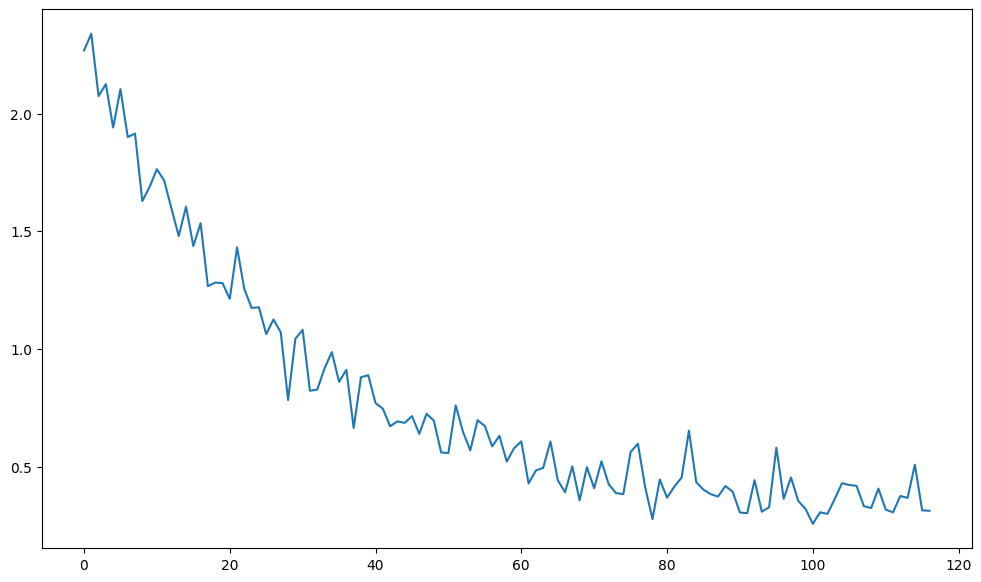

In [18]:
plot_loss(loss_history, save=False)

## Classify new data

In [19]:
def predict_image(model, image_path, show_image=False):
    # Ensure the model is in evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path)
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(input_image)
        _, predicted_class = torch.max(output, 1)

    # Map the predicted class index to the corresponding class label
    predicted_class_label = train_data.classes[predicted_class.item()]

    if show_image:# Display the image and the prediction
        plt.imshow(image)
        plt.title(f'Predicted class: {train_data.classes[predicted_class.item()]}')
        plt.axis(False)
        plt.show()

    return predicted_class_label

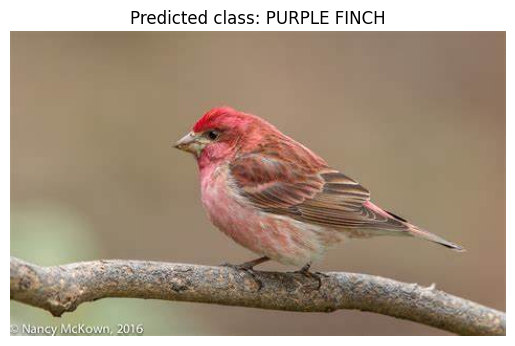

'PURPLE FINCH'

In [24]:
predict_image(model, "birb-images/purple-finch.jpg", show_image=True)

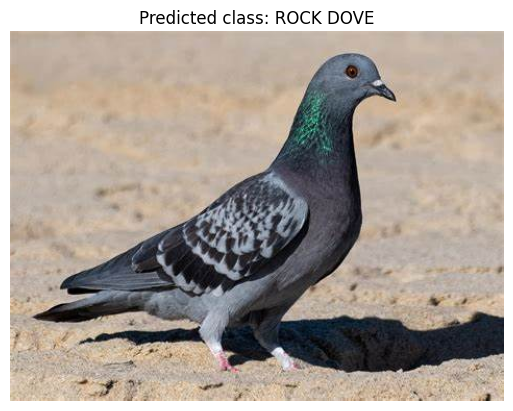

'ROCK DOVE'

In [22]:
predict_image(model, "birb-images/rock-dove.jpg", show_image=True)

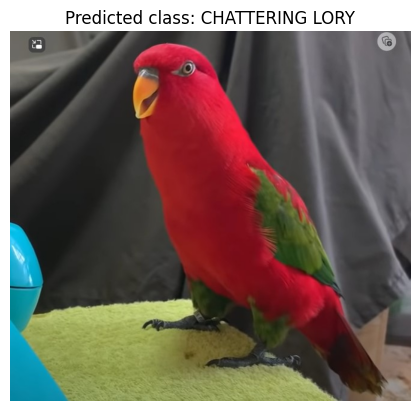

'CHATTERING LORY'

In [23]:
predict_image(model, "birb-images/red-birb.jpg", show_image=True)

## Object detection on CUB 200-2011

Maybe try this:
- https://discuss.pytorch.org/t/how-to-load-cub-200-2011-in-pytorch/97784/2
- https://github.com/ChikinH/DeepLearning/blob/main/CUB_200_2011_CNN_YOLO.ipynb
- https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=Bj_riya9wjJI
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- https://github.com/Yangqing/iceberk/blob/master/visiondata/_cub.py

In [1]:
import torch 
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

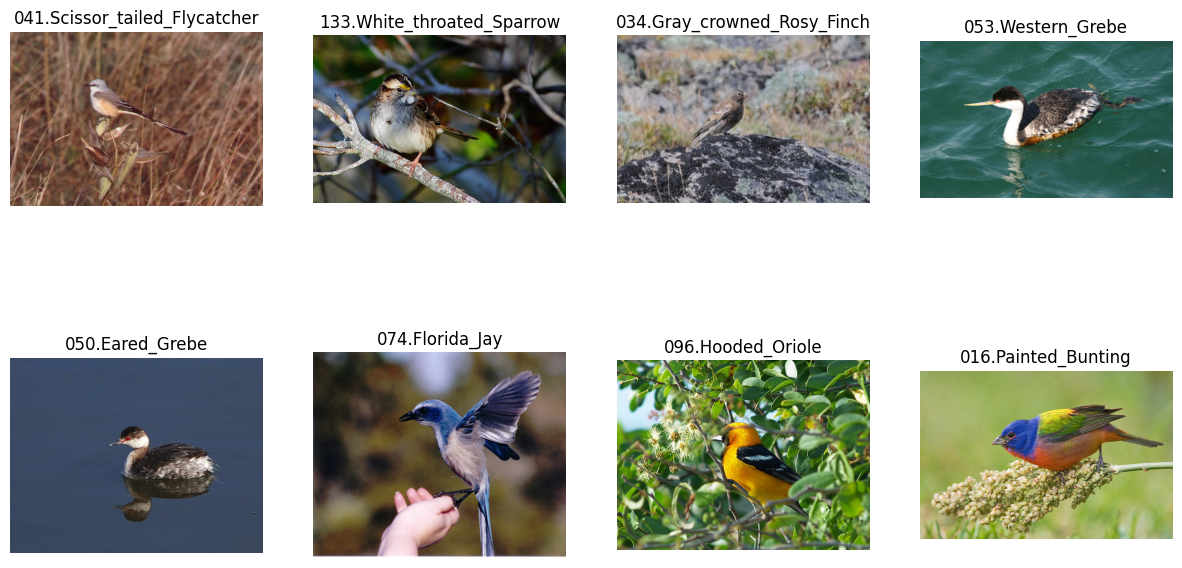

In [75]:
show_random_birbs(img_dir="./cub-200-2011/images")

In [ ]:
get_height_width(path="./cub-200-2011/images/035.Purple_Finch/Purple_Finch_0001_27571.jpg")

In [163]:
import pandas as pd
from PIL import Image

# Function to load an image and get its original dimensions
def get_original_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size  # Returns (width, height)

# Load the class labels
class_labels = pd.read_csv("cub-200-2011/image_class_labels.txt", sep=" ", header=None)
class_labels.columns = ["Image", "Label"]

# Load the bounding boxes
bounding_boxes = pd.read_csv("cub-200-2011/bounding_boxes.txt", sep=" ", header=None)
bounding_boxes.columns = ["Image", "x", "y", "width", "height"]

# Merge the two dataframes on the Image column
data = pd.merge(class_labels, bounding_boxes, on='Image')

# Create a list of ones with the same length as your data
objectness_labels = [1] * len(data)

# Convert the list to a pandas Series
objectness_labels = pd.Series(objectness_labels, name="Objectness")

# Add the objectness labels to your data
data = pd.concat([data, objectness_labels], axis=1)

# New dimensions
new_width = 224
new_height = 224

# Apply the function to each image in your data
# Replace 'Image' with the name of the column that contains your image paths
data['original_width'], data['original_height'] = zip(*data['Image'].apply(get_original_dimensions))

# Calculate scale factors and apply them to bounding boxes
data['x'] *= new_width / data['original_width']
data['y'] *= new_height / data['original_height']
data['width'] *= new_width / data['original_width']
data['height'] *= new_height / data['original_height']


AttributeError: 'int' object has no attribute 'read'

In [162]:
data

,Image,Label,x,y,width,height,Objectness
0,1,1,60.0,27.0,325.0,304.0,1
1,2,1,139.0,30.0,153.0,264.0,1
2,3,1,14.0,112.0,388.0,186.0,1
3,4,1,112.0,90.0,255.0,242.0,1
4,5,1,70.0,50.0,134.0,303.0,1
...,...,...,...,...,...,...,...
11783,11784,200,89.0,95.0,354.0,250.0,1
11784,11785,200,157.0,62.0,184.0,219.0,1
11785,11786,200,190.0,102.0,198.0,202.0,1
11786,11787,200,3.0,20.0,408.0,307.0,1


In [137]:
# Assuming bbox is a list of bounding boxes in the format [x_min, y_min, x_max, y_max]
# and img_size is the original size of the image in the format [width, height]

def normalize_bbox(bbox, img_size):
    bbox[0] /= img_size[0]  # x_min
    bbox[2] /= img_size[0]  # x_max
    bbox[1] /= img_size[1]  # y_min
    bbox[3] /= img_size[1]  # y_max
    return bbox

def denormalize_bbox(bbox, img_size):
    bbox[0] *= img_size[0]  # x_min
    bbox[2] *= img_size[0]  # x_max
    bbox[1] *= img_size[1]  # y_min
    bbox[3] *= img_size[1]  # y_max
    return bbox

img_size = (224, 224)

In [138]:
import torch 
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

class BirdDataset(ImageFolder):
    def __init__(self, root, data, objectness_labels, transform=None):
        super().__init__(root, transform=transform)
        self.data = data
        self.objectness_labels = objectness_labels

    def __getitem__(self, index):
        # Get the image and label like usual
        img, label = super().__getitem__(index)

        # Get the image name from the file path
        image_name = self.imgs[index][0].split('/')[-1].split('.')[0]

        # Extract only the number from the image name
        image_number = ''.join(filter(str.isdigit, image_name))

        # Get the bounding box for this image
        bbox = self.data[self.data['Image'] == int(image_number)][['x', 'y', 'width', 'height']].values[0]

        # Get the objectness label for this image
        objectness_label = self.objectness_labels[int(image_number)]

        return img, label, bbox, objectness_label

In [141]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the dataset
dataset = BirdDataset("cub-200-2011/images", data, objectness_labels=objectness_labels, transform=transform)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [142]:
class BirdNetOD(nn.Module):
    def __init__(self, num_classes):
        super(BirdNetOD, self).__init__()

        # Load the pretrained ResNet model
        self.resnet = models.resnet18(pretrained=True)

        # Number of features in the last layer of ResNet
        num_features = self.resnet.fc.in_features

        # Remove the last layer (fully connected layer) of ResNet
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Freeze the layers of the ResNet feature extractor
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Add separate fully connected layers for class scores, bounding box coordinates, and objectness
        self.fc_class_scores = nn.Linear(num_features, num_classes)
        self.fc_bbox_coords1 = nn.Linear(num_features, 100)
        self.fc_bbox_coords2 = nn.Linear(100, 20)
        self.fc_bbox_coords3 = nn.Linear(20, 4)
        self.fc_objectness_scores = nn.Linear(num_features, num_classes)

        # Store the number of classes
        self.num_classes = num_classes

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)

        # Compute class scores, bounding box coordinates, and objectness scores using their respective layers
        class_scores = self.fc_class_scores(x)
        bbox_coords = F.relu(self.fc_bbox_coords1(x))
        bbox_coords = F.relu(self.fc_bbox_coords2(bbox_coords))
        bbox_coords = torch.relu(self.fc_bbox_coords3(bbox_coords)).view(-1, 4)
        objectness_scores = self.fc_objectness_scores(x)

        return class_scores, objectness_scores, bbox_coords

In [143]:
class YOLOLoss(nn.Module):
    def __init__(self, class_loss_weight=1.0, objectness_loss_weight=1.0, localization_loss_weight=1.0):
        super(YOLOLoss, self).__init__()
        self.class_loss_weight = class_loss_weight
        self.objectness_loss_weight = objectness_loss_weight
        self.localization_loss_weight = localization_loss_weight
        self.mse_loss = nn.MSELoss()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, class_scores, objectness_scores, bbox_coords, class_labels, objectness_labels, bboxes):
        # Compute the classification loss
        class_loss = F.cross_entropy(class_scores, class_labels)

        # Compute the objectness loss
        objectness_scores = objectness_scores.reshape(-1, 1)
        objectness_labels = objectness_labels.view(-1, 1).repeat(1, 200).view(-1, 1).float()
        objectness_loss = self.bce_loss(objectness_scores, objectness_labels)

        # Compute the localization loss
        localization_loss = 0
        for i in range(bbox_coords.shape[1]):
            pred_centers = bbox_coords[:, :2]
            pred_sizes = torch.abs(bbox_coords[:, 2:])  # remove the square root
            gt_centers = bboxes[:, :2]
            gt_sizes = bboxes[:, 2:]

            localization_loss += self.smooth_l1_loss(pred_centers, gt_centers) + self.smooth_l1_loss(pred_sizes, gt_sizes)
        localization_loss /= bbox_coords.shape[1]

        # Sum up the losses with weights
        loss = self.class_loss_weight * class_loss + self.objectness_loss_weight * objectness_loss + self.localization_loss_weight * localization_loss

        return loss, class_loss, objectness_loss, localization_loss


In [144]:
from torchinfo import summary 

model_od = BirdNetOD(num_classes=200).to(device)
print(summary(model_od, input_size=(32, 3, 224, 224)))

C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
BirdNetOD                                     [32, 200]                 --
├─Sequential: 1-1                             [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          (73,984)
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          (73,984)
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 28, 28]         (230,144)
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]     

In [145]:
for name, param in model_od.named_parameters():
    print(name, param.requires_grad)

resnet.0.weight False
resnet.1.weight False
resnet.1.bias False
resnet.4.0.conv1.weight False
resnet.4.0.bn1.weight False
resnet.4.0.bn1.bias False
resnet.4.0.conv2.weight False
resnet.4.0.bn2.weight False
resnet.4.0.bn2.bias False
resnet.4.1.conv1.weight False
resnet.4.1.bn1.weight False
resnet.4.1.bn1.bias False
resnet.4.1.conv2.weight False
resnet.4.1.bn2.weight False
resnet.4.1.bn2.bias False
resnet.5.0.conv1.weight False
resnet.5.0.bn1.weight False
resnet.5.0.bn1.bias False
resnet.5.0.conv2.weight False
resnet.5.0.bn2.weight False
resnet.5.0.bn2.bias False
resnet.5.0.downsample.0.weight False
resnet.5.0.downsample.1.weight False
resnet.5.0.downsample.1.bias False
resnet.5.1.conv1.weight False
resnet.5.1.bn1.weight False
resnet.5.1.bn1.bias False
resnet.5.1.conv2.weight False
resnet.5.1.bn2.weight False
resnet.5.1.bn2.bias False
resnet.6.0.conv1.weight False
resnet.6.0.bn1.weight False
resnet.6.0.bn1.bias False
resnet.6.0.conv2.weight False
resnet.6.0.bn2.weight False
resnet.6.0.bn

In [146]:
torch.autograd.set_detect_anomaly(True)

In [147]:
class_loss_weight = 1.0
objectness_loss_weight = 0.1
localization_loss_weight = 1.0  # reduce the weight of the localization loss

loss_fn = YOLOLoss(class_loss_weight, objectness_loss_weight, localization_loss_weight)


# Define the optimizer
optimizer = torch.optim.Adam(model_od.parameters(), lr=0.001)

# Number of epochs
epochs = 6
loss_history = []
accuracy_history = []  # Store accuracy for each step

# Start the training loop
for epoch in range(epochs):
    for i, (images, labels, bboxes, objectness_labels) in enumerate(dataloader):  # Load objectness_labels from your dataloader
        correct = 0  # Reset correct count for each batch
        total = 0  # Reset total count for each batch

        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.long().to(device)
        bboxes = bboxes.float().to(device)
        objectness_labels = objectness_labels.long().to(device)  # Move objectness_labels to the device

        class_scores = class_scores.float()
        objectness_scores = objectness_scores.float()
        bbox_coords = bbox_coords.float()

        # Pass data through model
        class_scores, objectness_scores, bbox_coords = model_od(images)

        # Convert predictions back to original scale
        for i in range(len(bbox_coords)):
            bbox_coords[i] = denormalize_bbox(bbox_coords[i], img_size)

        # Compute the loss
        loss, class_loss, objectness_loss, localization_loss = loss_fn(class_scores, objectness_scores, bbox_coords, labels, objectness_labels, bboxes)

        # Calculate accuracy
        _, predicted = torch.max(class_scores.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        for name, param in model_od.named_parameters():
            if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                print(f"Warning: NaN or inf found in gradient of {name}")

        optimizer.step()

        # Print progress
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}, Accuracy: {accuracy}%')
            print(f"Class loss: {class_loss} | Objectness loss: {objectness_loss} | localization loss: {localization_loss}\n")
            loss_history.append(loss.item())

    # Save the model weights every 5 epochs
    if (epoch + 1) % 3 == 0:
        torch.save(model_od.state_dict(), f"./models/birdnet18-od-weights-{epoch+1}.pt")
        print(f"Model weights saved at epoch {epoch+1}")

    print(f'Epoch [{epoch+1}/{epochs}] Completed, Avg Loss: {loss.item()}, Accuracy: {accuracy}%')

IndexError: index 174 is out of bounds for dimension 0 with size 32

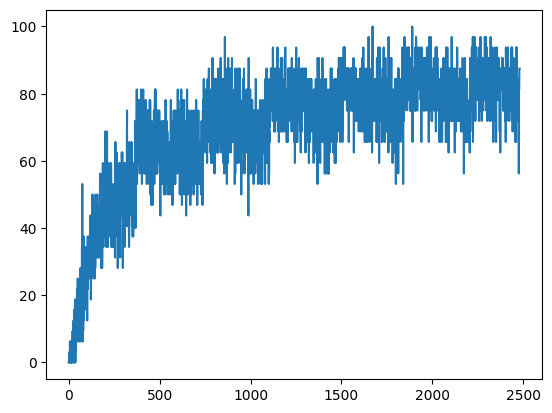

In [24]:
import matplotlib.pyplot as plt
plt.plot(accuracy_history)
plt.savefig("loss.png")

In [ ]:
torch.save(model_od.state_dict(), "./models/birbnet-18-od-weights.pt")

In [ ]:
# Assuming that you have your trained model defined as `model_od`
model_od = BirbNet()  # replace `YourModel` with the class name of your model

# Now load the state dict
state_dict = torch.load("./models/birbnet-18-od-weights.pt")  # replace with the path to your .pth file

# Load the state dict into the model
model_od.load_state_dict(state_dict)

# Don't forget to call model.eval() to set dropout and batch norm layers to evaluation mode before running inference
model_od.eval()

In [29]:
def convert_coords(bbox_coords):
    # Convert from [x_center, y_center, width, height] to [x_min, y_min, x_max, y_max]
    bboxes = []
    for bbox in bbox_coords:
        x_center, y_center, width, height = bbox
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
        bboxes.append([x_min, y_min, x_max, y_max])
    return torch.tensor(bboxes)


In [95]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the image
image = Image.open("birb-images/green-violetear.jpg")

# Resize the image to the size your model was trained on
image = image.resize((224, 224))

# Convert the image to a PyTorch tensor and add an extra dimension for the batch size
image_tensor = transform(image).unsqueeze(0).to(device)

In [96]:
model_od.eval()
# Forward pass through the model
class_scores, objectness_scores, bbox_coords = model_od(image_tensor)

In [97]:
def load_class_names(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        
    class_names = {}
    for line in lines:
        split_line = line.strip().split(' ')
        class_id = int(split_line[0])
        class_name = ' '.join(split_line[1:])
        class_names[class_id] = class_name
        
    return class_names

# Usage
filename = "./cub-200-2011/classes.txt"
class_names = load_class_names(filename)

In [98]:
def clip_boxes(boxes, img_size):
    # Convert to a tensor if it's a list
    if isinstance(boxes, list):
        boxes = torch.tensor(boxes)

    # Make sure x_min and y_min are not less than 0
    boxes[:, 0].clamp_(min=0)
    boxes[:, 1].clamp_(min=0)

    # Make sure x_max and y_max are not more than the image size
    boxes[:, 2].clamp_(max=img_size[0])
    boxes[:, 3].clamp_(max=img_size[1])

    return boxes

tensor([[ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],
        [ 46.1845,  60.9989, 210.5697, 187.9426],


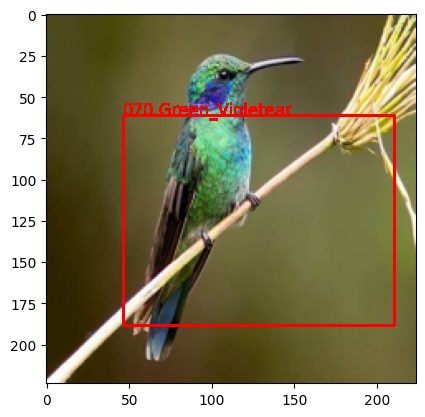

In [99]:
# Apply a threshold to the objectness scores to filter out low-confidence predictions
objectness_threshold = 0.5
high_confidence_indices = (objectness_scores > objectness_threshold)

# Use these indices to select only the high-confidence class scores and bounding boxes
high_confidence_class_scores = class_scores[high_confidence_indices]
high_confidence_bbox_coords = bbox_coords[torch.where(high_confidence_indices)[0]]

# Convert the bounding box coordinates from [x_center, y_center, width, height] to [x_min, y_min, x_max, y_max]
bboxes = convert_coords(high_confidence_bbox_coords)

# Convert all bounding box coordinates to positive
bboxes = abs(bboxes)
print(bboxes)

# Use the class scores to determine the class label for each bounding box
class_labels = torch.argmax(high_confidence_class_scores).item()
print(class_labels)

# Now you have the class labels and bounding boxes for the objects detected in your image!

# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a Rectangle patch for each bounding box and add it to the axes
for i in range(len(bboxes)):
    bbox = bboxes[i]
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(bbox[0], bbox[1], class_names[class_labels+1], fontsize=12, color='r')

# Show the figure
plt.show()
